# 01 Data Downloader & Cleanser for PubMed Journals

---

In [1]:
## Load common things
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## 1. Data Download

## 2. Data Loader


In [2]:
def get_cached_data(filepath):
    with open(filepath) as f:
        return f.readlines()

---

#### `TO-DO`: Change the file path if on server!

In [3]:
cached_dataset_dir = 'pre-cached-dt/'

train_data = get_cached_data(cached_dataset_dir + 'train.txt')
train_file_path = cached_dataset_dir+'train.txt'
val_file_path = cached_dataset_dir+'val.txt'
test_file_path = cached_dataset_dir+'test.txt'

**Visual Inspection**: Just to see if it is loaded properly.

In [4]:
# View the first 5 lines from the training data
train_data[:5]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n"]

---

### 2.1 Data Separation

In order to prepare the dataset for the training of our neural network, several key preprocessing steps must be undertaken. These involve transforming the raw corpus of medical research articles into a format that our neural network can understand and learn from.

One of the essential steps in this preprocessing pipeline is to clearly delineate the beginning and end of each abstract within the overall corpus. This is crucial as each abstract represents a distinct unit of information, and these need to be distinctly identifiable for the machine learning algorithm. Mixing up the data from different abstracts can lead to inaccurate predictions and learning inaccuracies.

Thus, we must first identify where each abstract starts and where it ends in our data. This involves looking for specific markers or patterns that indicate the start and end of an abstract. Once we can accurately identify these markers, we can extract the abstract in its entirety as a distinct data point.

This "segmentation" of the corpus allows us to handle each abstract as an individual unit of analysis. By doing so, we ensure that the algorithm can accurately learn the structure and semantics of individual abstracts, rather than treating the entire corpus as one continuous piece of text. This is vital in our case, where each abstract represents a unique piece of research and should be treated as such.

**`TLDR`**: The goal of this stage of preprocessing is to convert the raw corpus into a structured dataset, where each row represents a unique abstract. This involves identifying the start and end of each abstract and then extracting the core content for analysis. This structured dataset is then ready to be used in training our neural network.

In [5]:
def data_separator(filepath):
    raw_data = get_cached_data(filepath)
    abstract_data = ''
    abstract_samples = []
    abstract_id = 0

    for line in tqdm(raw_data):
        # See if the id is there, see the visual example above
        if line.startswith('###'):
            abstract_id = int(line.replace('###', '').replace('\n', ''))
            abstract_data = ''

        elif line.isspace(): # Find new line \n thingy
            abstract_data_split = abstract_data.splitlines()
            
            for abstract_line_number, abstract_line in enumerate(abstract_data_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                
                # Fetch abstract ID
                line_data["abstract_id"] = abstract_id
                # Then, we index each line of the abstract
                line_data["line_id"] = f'{abstract_id}_{abstract_line_number}_{len(abstract_data_split)}'
                
                # Take the target portion out
                line_data["abstract_text"] = target_text_split[1]
                # Get the row index of the line
                line_data["line_number"] = abstract_line_number
                
                # Count total number of lines, and the indexing starts at 1
                line_data["total_lines"] = len(abstract_data_split)
                
                # Concat two things into one feature
                line_data['current_line'] = f'{abstract_line_number}_{len(abstract_data_split)}'
                
                # Create the label
                line_data["target"] = target_text_split[0]
                
                # Data can be transform and append together
                abstract_samples.append(line_data)

        else: # When format is not rigid
            abstract_data += line
            
    # Yield final lib of text
    return abstract_samples

Then, we use the function to get the training data ready.

In [6]:
# Get train data from file and preprocess it
# The path shall be defined at the beginning

if os.path.exists(train_file_path):
    print("The training file exists. Loading it again for pre-processing...")
    do_exist_train = True
    train_samples = data_separator(train_file_path)
else:
    do_exist_train = False
    print("The training file does not exist, please rewind!")

The training file exists. Loading it again for pre-processing...


100%|██████████| 2593169/2593169 [00:05<00:00, 483726.85it/s]


In [7]:
if os.path.exists(val_file_path):
    print("The validation file exists. Loading it again for pre-processing...")
    do_exist_val = True
    val_samples = data_separator(val_file_path)
else:
    do_exist_val = False
    print("The validation file does not exist, please rewind!")

The validation file exists. Loading it again for pre-processing...


100%|██████████| 33932/33932 [00:00<00:00, 493079.97it/s]


In [8]:
if os.path.exists(test_file_path):
    print("The test file exists. Loading it again for pre-processing...")
    do_exist_test = True
    test_samples = data_separator(test_file_path)
else:
    do_exist_test = False
    print("The validation file does not exist, please rewind!")

The test file exists. Loading it again for pre-processing...


100%|██████████| 34493/34493 [00:00<00:00, 514664.07it/s]


Check if ready to move on.

In [9]:
if do_exist_test and do_exist_val and do_exist_train:
    print('Data loaded successfully!')
    print('# of training samples   = ', len(train_samples))
    print('# of validation samples = ', len(val_samples))
    print('# of test samples       = ', len(test_samples))
else:
    if not do_exist_test:
        print('Test data is missing! Please rewind!')
    if not do_exist_val:
        print('Validation data is missing! Please rewind!')
    if not do_exist_train:
        print('Training data is missing! Please rewind!')

Data loaded successfully!
# of training samples   =  2211861
# of validation samples =  28932
# of test samples       =  29493


---

### 2.2 Data Transformation for NN Training

Given that the current data is stored in a dictionary and a list, it is necessary to transform them into a pandas dataframe before proceeding with the training of the neural network. This transformation is required because the neural network typically expects the data to be in a tabular format with well-defined columns.

**`Visual Inspection`**: For safety purpose.

In [10]:
train_samples[:5]

[{'abstract_id': 24491034,
  'line_id': '24491034_0_11',
  'abstract_text': 'The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'line_number': 0,
  'total_lines': 11,
  'current_line': '0_11',
  'target': 'BACKGROUND'},
 {'abstract_id': 24491034,
  'line_id': '24491034_1_11',
  'abstract_text': 'This paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .',
  'line_number': 1,
  'total_lines': 11,
  'current_line': '1_11',
  'target': 'BACKGROUND'},
 {'abstract_id': 24491034,
  'line_id': '24491034_2_11',
  'abstract_text': 'This study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .',
  'line_nu

In [11]:
val_samples[:5]

[{'abstract_id': 15337700,
  'line_id': '15337700_0_9',
  'abstract_text': 'Adrenergic activation is thought to be an important determinant of outcome in subjects with chronic heart failure ( CHF ) , but baseline or serial changes in adrenergic activity have not been previously investigated in a large patient sample treated with a powerful antiadrenergic agent .',
  'line_number': 0,
  'total_lines': 9,
  'current_line': '0_9',
  'target': 'BACKGROUND'},
 {'abstract_id': 15337700,
  'line_id': '15337700_1_9',
  'abstract_text': 'Systemic venous norepinephrine was measured at baseline , 3 months , and 12 months in the beta-Blocker Evaluation of Survival Trial ( BEST ) , which compared placebo treatment with the beta-blocker/sympatholytic agent bucindolol .',
  'line_number': 1,
  'total_lines': 9,
  'current_line': '1_9',
  'target': 'RESULTS'},
 {'abstract_id': 15337700,
  'line_id': '15337700_2_9',
  'abstract_text': 'Baseline norepinephrine level was associated with a progressive inc

In [12]:
test_samples[:5]

[{'abstract_id': 24562799,
  'line_id': '24562799_0_11',
  'abstract_text': 'Many pathogenic processes and diseases are the result of an erroneous activation of the complement cascade and a number of inhibitors of complement have thus been examined for anti-inflammatory actions .',
  'line_number': 0,
  'total_lines': 11,
  'current_line': '0_11',
  'target': 'BACKGROUND'},
 {'abstract_id': 24562799,
  'line_id': '24562799_1_11',
  'abstract_text': 'It was recently demonstrated that supraphysiological concentrations of the endogenous complement inhibitor MAp44 ( also denoted MAP1 ) protect against myocardial reperfusion injury .',
  'line_number': 1,
  'total_lines': 11,
  'current_line': '1_11',
  'target': 'BACKGROUND'},
 {'abstract_id': 24562799,
  'line_id': '24562799_2_11',
  'abstract_text': 'In the present study , we examined the association between outcome after acute myocardial infarction ( MI ) and the plasma levels of MAp44 and its related proteins MASP-1 and MASP-3 in patie

Now we convert them all into dataframes.

In [13]:
# Deadly simple
df_train = pd.DataFrame(train_samples)
df_val = pd.DataFrame(val_samples)
df_test = pd.DataFrame(test_samples)

**`Visual Inspection`**: For safety purpose.

In [14]:
df_train.head(5)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24491034,24491034_0_11,The emergence of HIV as a chronic condition me...,0,11,0_11,BACKGROUND
1,24491034,24491034_1_11,This paper describes the design and evaluation...,1,11,1_11,BACKGROUND
2,24491034,24491034_2_11,This study is designed as a randomised control...,2,11,2_11,METHODS
3,24491034,24491034_3_11,The intervention group will participate in the...,3,11,3_11,METHODS
4,24491034,24491034_4_11,The program is based on self-efficacy theory a...,4,11,4_11,METHODS


In [15]:
df_val.head(5)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,15337700,15337700_0_9,Adrenergic activation is thought to be an impo...,0,9,0_9,BACKGROUND
1,15337700,15337700_1_9,Systemic venous norepinephrine was measured at...,1,9,1_9,RESULTS
2,15337700,15337700_2_9,Baseline norepinephrine level was associated w...,2,9,2_9,RESULTS
3,15337700,15337700_3_9,"On multivariate analysis , baseline norepineph...",3,9,3_9,RESULTS
4,15337700,15337700_4_9,"In contrast , the relation of the change in no...",4,9,4_9,RESULTS


In [16]:
df_test.head(5)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24562799,24562799_0_11,Many pathogenic processes and diseases are the...,0,11,0_11,BACKGROUND
1,24562799,24562799_1_11,It was recently demonstrated that supraphysiol...,1,11,1_11,BACKGROUND
2,24562799,24562799_2_11,"In the present study , we examined the associa...",2,11,2_11,BACKGROUND
3,24562799,24562799_3_11,"In addition , we compared plasma levels of MAp...",3,11,3_11,BACKGROUND
4,24562799,24562799_4_11,A total of 192 MI patients and 140 control per...,4,11,4_11,METHODS


In the `training data`, let's see how many labels we have.

In [17]:
label_counts = df_train['target'].value_counts()
label_counts = label_counts.sort_index(ascending=True)
label_counts

BACKGROUND     196689
CONCLUSIONS    339714
METHODS        722586
OBJECTIVE      186601
RESULTS        766271
Name: target, dtype: int64

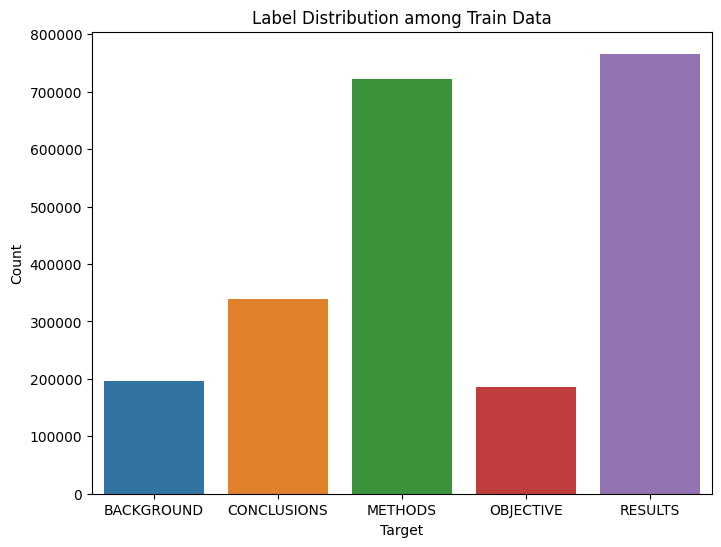

In [18]:
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Label Distribution among Train Data')
plt.show()

In the `validation data`, let's see how many labels we have.

In [19]:
label_counts = df_val['target'].value_counts()
label_counts = label_counts.sort_index(ascending=True)
label_counts

BACKGROUND     2575
CONCLUSIONS    4396
METHODS        9559
OBJECTIVE      2425
RESULTS        9977
Name: target, dtype: int64

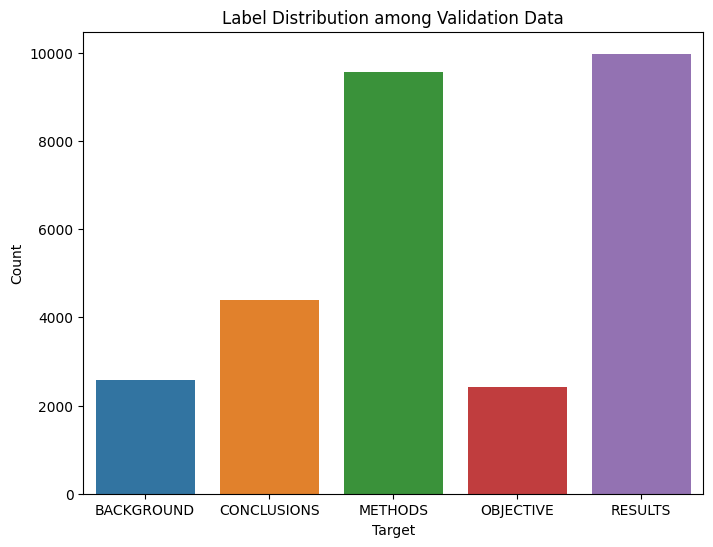

In [20]:
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Label Distribution among Validation Data')
plt.show()

In the `test data`, let's see how many labels we have.

In [21]:
label_counts = df_test['target'].value_counts()
label_counts = label_counts.sort_index(ascending=True)
label_counts

BACKGROUND      2663
CONCLUSIONS     4426
METHODS         9751
OBJECTIVE       2377
RESULTS        10276
Name: target, dtype: int64

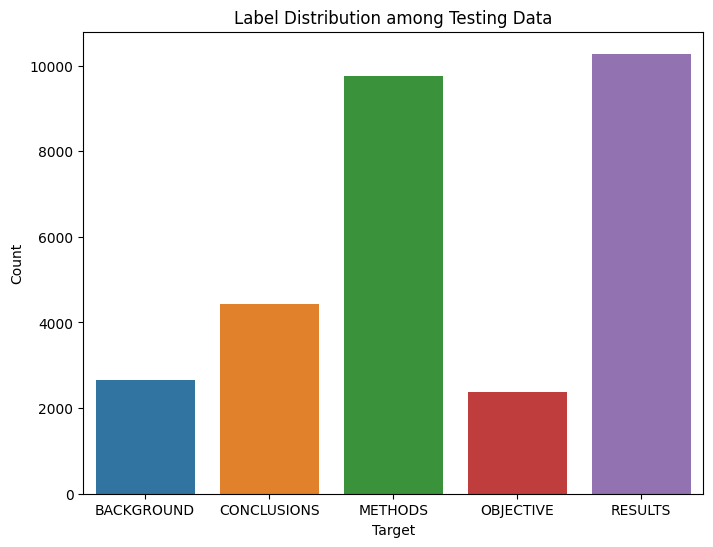

In [22]:
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Label Distribution among Testing Data')
plt.show()

_**Well**_, the distributions of labels among train, val, test are not perfect. We could possible shuffle things around or get a better cut of the dataset. Let's see if it is needed to optimize the data stream.

---

### 2.3 Input Sequence Construction

Since we have already transformed our dataset into usable pandas dataframe, now we need to construct the data pipeline for input of the neural network model.

To construct the data pipeline for the input of the neural network model using the transformed pandas dataframe, we need to transform the usable portion back to list.

In [23]:
try:
    train_sentences = df_train["abstract_text"].tolist()
    print('Train input list success!')
except Exception as e:
    print("Error encountered! Please rewind!")
    print(e)

Train input list success!


In [24]:
try:
    val_sentences = df_val["abstract_text"].tolist()
    print('Validation input list success!')
except Exception as e:
    print("Error encountered! Please rewind!")
    print(e)

Validation input list success!


In [25]:
try:
    test_sentences = df_test["abstract_text"].tolist()
    print('Testing input list success!')
except Exception as e:
    print("Error encountered! Please rewind!")
    print(e)

Testing input list success!


Check the size of the dataset.

In [26]:
train_sentences_count = len(train_sentences)
val_sentences_count = len(val_sentences)
test_sentences_count = len(test_sentences)

In [27]:
print('# of sentences for training   = ', train_sentences_count)
print('# of sentences for validation = ', val_sentences_count)
print('# of sentences for testing    = ', test_sentences_count)

total_sentences_count = len(train_sentences) + len(val_sentences) + len(test_sentences)
print('# of sentences for total      = ', total_sentences_count)

# of sentences for training   =  2211861
# of sentences for validation =  28932
# of sentences for testing    =  29493
# of sentences for total      =  2270286


**`Visual Inspection`**: For safety purpose.

In [28]:
train_sentences[:5]

['The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'This paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .',
 'This study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .',
 "The intervention group will participate in the online group program ` Positive Outlook ' .",
 'The program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .']

In [29]:
val_sentences[:5]

['Adrenergic activation is thought to be an important determinant of outcome in subjects with chronic heart failure ( CHF ) , but baseline or serial changes in adrenergic activity have not been previously investigated in a large patient sample treated with a powerful antiadrenergic agent .',
 'Systemic venous norepinephrine was measured at baseline , 3 months , and 12 months in the beta-Blocker Evaluation of Survival Trial ( BEST ) , which compared placebo treatment with the beta-blocker/sympatholytic agent bucindolol .',
 'Baseline norepinephrine level was associated with a progressive increase in rates of death or death plus CHF hospitalization that was independent of treatment group .',
 'On multivariate analysis , baseline norepinephrine was also a highly significant ( P < 0.001 ) independent predictor of death .',
 'In contrast , the relation of the change in norepinephrine at 3 months to subsequent clinical outcomes was complex and treatment group-dependent .']

In [30]:
test_sentences[:5]

['Many pathogenic processes and diseases are the result of an erroneous activation of the complement cascade and a number of inhibitors of complement have thus been examined for anti-inflammatory actions .',
 'It was recently demonstrated that supraphysiological concentrations of the endogenous complement inhibitor MAp44 ( also denoted MAP1 ) protect against myocardial reperfusion injury .',
 'In the present study , we examined the association between outcome after acute myocardial infarction ( MI ) and the plasma levels of MAp44 and its related proteins MASP-1 and MASP-3 in patients with first-time MI .',
 'In addition , we compared plasma levels of MAp44 , MASP-1 , and MASP-3 in MI patients to levels in a healthy control group .',
 'A total of 192 MI patients and 140 control persons were included .']

---

## 3. Neural Network Construction

Now, we are ready to train our corpus.

### 3.1 Encoding

We use the `OneHotEncoder` from `scikit-learn` since it is just fast and convenient.

In [31]:
# !pip install scikit-learn scipy

In [32]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef, classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

In [33]:
one_hot_encoder = OneHotEncoder(sparse=False)

Perform encoding on the labels.

In [34]:
one_hot_encoder_train_labels = one_hot_encoder.fit_transform(df_train["target"].to_numpy().reshape(-1, 1))
one_hot_encoder_val_labels = one_hot_encoder.transform(df_val["target"].to_numpy().reshape(-1, 1))
one_hot_encoder_test_labels = one_hot_encoder.transform(df_test["target"].to_numpy().reshape(-1, 1))

/home/jupyter-doggo/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**`Visual Inspection`**: For safety purpose.

In [35]:
one_hot_encoder_train_labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [36]:
df_train["target"][0]

'BACKGROUND'

In [37]:
one_hot_encoder_train_labels.shape

(2211861, 5)

Do the same thing with the labels.

In [38]:
label_encoder = LabelEncoder()

In [39]:
encoded_train_labels = label_encoder.fit_transform(df_train["target"].to_numpy())
encoded_val_labels = label_encoder.transform(df_val["target"].to_numpy())
encoded_test_labels = label_encoder.transform(df_test["target"].to_numpy())

**`Visual Inspection`**: For safety purpose.

In [40]:
encoded_train_labels

array([0, 0, 2, ..., 4, 4, 4])

In [41]:
encoded_train_labels.shape

(2211861,)

In [42]:
# Take out class names
number_label_class = len(label_encoder.classes_)
class_names = label_encoder.classes_

In [43]:
print('# of classes = ', number_label_class, '\t (should expect 5)')

# of classes =  5 	 (should expect 5)


In [44]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

Now we deal with the lines.

In [45]:
line_one_hot_encoder = OneHotEncoder(sparse=False)

In [46]:
# from tqdm import tqdm

# train_lines_encoded = []
# total_samples = len(df_train["current_line"])

# for line in tqdm(df_train["current_line"].to_numpy().reshape(-1, 1), total=total_samples):
#     encoded_line = line_one_hot_encoder.fit_transform(line).astype(np.float32)
#     train_lines_encoded.append(encoded_line)

# train_lines_encoded = np.concatenate(train_lines_encoded, axis=0)


In [47]:
train_lines_encoded = line_one_hot_encoder.fit_transform(df_train["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)

/home/jupyter-doggo/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [48]:
val_lines_encoded = line_one_hot_encoder.transform(df_val["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)

In [49]:
test_lines_encoded = line_one_hot_encoder.transform(df_test["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)

**`Visual Inspection`**: For safety purpose.

In [50]:
train_lines_encoded

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [51]:
train_lines_encoded.shape

(2211861, 1017)

In [52]:
val_lines_encoded.shape

(28932, 1017)

In [53]:
test_lines_encoded.shape

(29493, 1017)

In [54]:
# Check if the shapes are matchable
if train_lines_encoded.shape[1] == val_lines_encoded.shape[1] and val_lines_encoded.shape[1] == test_lines_encoded.shape[1]:
    print('Encoded just fine!')
else:
    print('Error occured, please rewind!')

Encoded just fine!


### 3.2 Smoothing [Optinal]

This is optional, but can help.

> https://subscription.packtpub.com/book/data/9781838829131/12/ch12lvl1sec86/using-label-smoothing-to-increase-performance



In [55]:
def line_smoothing(line_one_hot_encoded, esp):
    return np.abs(line_one_hot_encoded - esp)

def undo_smoothing(smoothed_line_one_hot_encoded, esp):
    rewinder = smoothed_line_one_hot_encoded
    
    rewinder[rewinder>esp] = 1.0
    rewinder[rewinder<=esp] = 0.0
    
    return rewinder

In [56]:
train_lines_encoded = line_smoothing(train_lines_encoded, 0.01)

In [57]:
train_lines_encoded.shape

(2211861, 1017)

---

### 3.3 Create Data Pipeline

In [58]:
# !pip install tensorflow_hub

In [59]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

2023-06-03 08:31:52.584230: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 08:31:52.707104: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-03 08:31:52.707135: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-03 08:31:53.954988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [60]:
def create_pipeline(features, labels, batch_size=32, shuffle=False, cache=False, prefetch=False) -> tf.data.Dataset:
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with features and labels
    dataset_block = tf.data.Dataset.from_tensor_slices((features, labels))
    
    # Apply shuffling based on condition
    if shuffle:
        dataset_block = dataset_block.shuffle(buffer_size=1000)
        
    # Apply batching
    dataset_block = dataset_block.batch(batch_size)
    
    # Only when small mem on laptop
    if cache:
        dataset_block = dataset_block.cache(buffer_size=AUTOTUNE)
    
    # Should be fine with server
    if prefetch:
        dataset_block = dataset_block.prefetch(buffer_size=AUTOTUNE)
    
    return dataset_block

#### `TO-DO`: Change batch size based on need.

In [61]:
BATCH_SIZE = 32

In [62]:
train_features = (train_sentences, train_lines_encoded.astype(np.float32)) 
train_labels = one_hot_encoder_train_labels.astype(np.float32)

In [63]:
train_pipes = create_pipeline(
    train_features, train_labels, 
    batch_size=BATCH_SIZE, shuffle=True, 
    cache=False, prefetch=True)

2023-06-03 08:32:03.652972: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-03 08:32:03.653014: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-03 08:32:03.653044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (huskyplayground): /proc/driver/nvidia/version does not exist
2023-06-03 08:32:03.653375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 08:32:04.178062: W tensorflow/tsl/framework/cpu_allocator

In [64]:
val_features = (val_sentences, val_lines_encoded.astype(np.float32)) 
val_labels = one_hot_encoder_val_labels.astype(np.float32)

In [65]:
val_pipes = create_pipeline(val_features, val_labels, 
                         batch_size=BATCH_SIZE, shuffle=False, 
                         cache=False, prefetch=True)

In [66]:
test_features = (test_sentences, test_lines_encoded.astype(np.float32)) 
test_labels = one_hot_encoder_test_labels.astype(np.float32)

In [67]:
test_pipes = create_pipeline(test_features, test_labels, 
                          batch_size=BATCH_SIZE, shuffle=False, 
                          cache=False, prefetch=True)

**`Visual Inspection`**: For safety purpose.

In [68]:
train_pipes

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 1017), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [69]:
val_pipes 

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 1017), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [70]:
test_pipes


<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 1017), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [71]:
temp_counter = 0
for data in test_pipes:
    if temp_counter < 1:
        # Print
        print(data)
        temp_counter = temp_counter + 1
    else:
        break

((<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Many pathogenic processes and diseases are the result of an erroneous activation of the complement cascade and a number of inhibitors of complement have thus been examined for anti-inflammatory actions .',
       b'It was recently demonstrated that supraphysiological concentrations of the endogenous complement inhibitor MAp44 ( also denoted MAP1 ) protect against myocardial reperfusion injury .',
       b'In the present study , we examined the association between outcome after acute myocardial infarction ( MI ) and the plasma levels of MAp44 and its related proteins MASP-1 and MASP-3 in patients with first-time MI .',
       b'In addition , we compared plasma levels of MAp44 , MASP-1 , and MASP-3 in MI patients to levels in a healthy control group .',
       b'A total of 192 MI patients and 140 control persons were included .',
       b'Plasma samples were obtained and analysed with time-resolved immunofluorometric assays determi

---

### 3.4 Model Download

In [72]:
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [73]:
# get Universal Sentence Encoder here
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only 

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

In [74]:
class SelfAttentionBlock(layers.Layer):
    
    def __init__(self, units: int, activation='gelu', kernel_initializer='GlorotNormal', **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kernel_initializer = tf.keras.initializers.deserialize(kernel_initializer)
        
        self.query = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, 
                                 return_sequences=True, name=f'block_query_lstm')
        
        self.value = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, go_backwards=True, 
                                 return_sequences=True, name=f'block_value_lstm')
        
        self.attention = layers.AdditiveAttention(name='block_attention')
        self.average_pooler = layers.GlobalAveragePooling1D(name='block_average_pooler')
        self.query_batch_norm = layers.BatchNormalization(name='block_query_batch_norm')
        self.attention_batch_norm = layers.BatchNormalization(name='block_attention_batch_norm')
        self.residual = layers.Add(name='block_residual')
        
        
    def __call__(self, x):
        # Expand dimensions for LSTMs
        dim_expand_layer = layers.Lambda(lambda embedding: tf.expand_dims(embedding, axis=1), name='block_dim_expand')
        x_expanded = dim_expand_layer(x)
        
        # Generate LSTM sequences
        block_query = self.query(x_expanded)
        block_value = self.value(x_expanded)
        
        # Apply self-attention to LSTM 
        block_attention = self.attention([block_query, block_value])
        
        # Apply GlobalAvgPooling and BatchNorm to ensure output shape is 1D 
        block_query_pooling = self.average_pooler(block_query)
        block_query_batch_norm = self.query_batch_norm(block_query_pooling)
        
        block_attention_pooling = self.average_pooler(block_attention)
        block_attention_batch_norm = self.attention_batch_norm(block_attention_pooling)
        
        # Generate addition residual with processed query and attention
        block_residual = self.residual([block_query_batch_norm, block_attention_batch_norm])
        
        return block_residual

In [75]:
def build_model():
    # Model Inputs
    #------------
    abstract_input = layers.Input(shape=[], dtype=tf.string, name='abstract_text_input')    
    abstract_current_line = layers.Input(shape=(1017), dtype=tf.float32, name='abstract_current_line')
    
    # Define Layer Initializer
    #------------
    initializer = tf.keras.initializers.GlorotNormal()

    # Text Embedding
    #------------
    abstract_embedding = encoder(abstract_input)
    
    # Self Attention Block Stream
    #------------
    add_attention_block = SelfAttentionBlock(64)(abstract_embedding)
    abstract_dense = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(abstract_embedding)
    attention_residual = layers.Multiply(name='mul_residual')([add_attention_block, abstract_dense])
    
    # Current Line Stream
    #------------
    current_line_dense = layers.Dense(32, activation='gelu', kernel_initializer=initializer)(abstract_current_line)
    current_line_dense = layers.Dropout(0.2)(current_line_dense)

    # Concat Streams
    #------------
    streams_concat = layers.Concatenate()([
        attention_residual,
        current_line_dense
    ])

    # Output Layer
    #------------
    output_layer = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(streams_concat)
    output_layer = layers.Dense(5, activation='softmax', kernel_initializer=initializer)(output_layer)

    return tf.keras.Model(inputs=[abstract_input, 
                                  abstract_current_line], 
                          outputs=[output_layer], name="use_attention_model")

**Before training process, make sure to check the model.**

In [76]:
# Build model
model = build_model()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
/home/jupyter-doggo/.local/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [77]:
model.summary()

Model: "use_attention_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 abstract_text_input (InputLaye  [(None,)]           0           []                               
 r)                                                                                               
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['abstract_text_input[0][0]']    
 rasLayer)                                                                                        
                                                                                                  
 block_dim_expand (Lambda)      (None, 1, 512)       0           ['universal_sentence_encoder[0][0
                                                                 ]']            

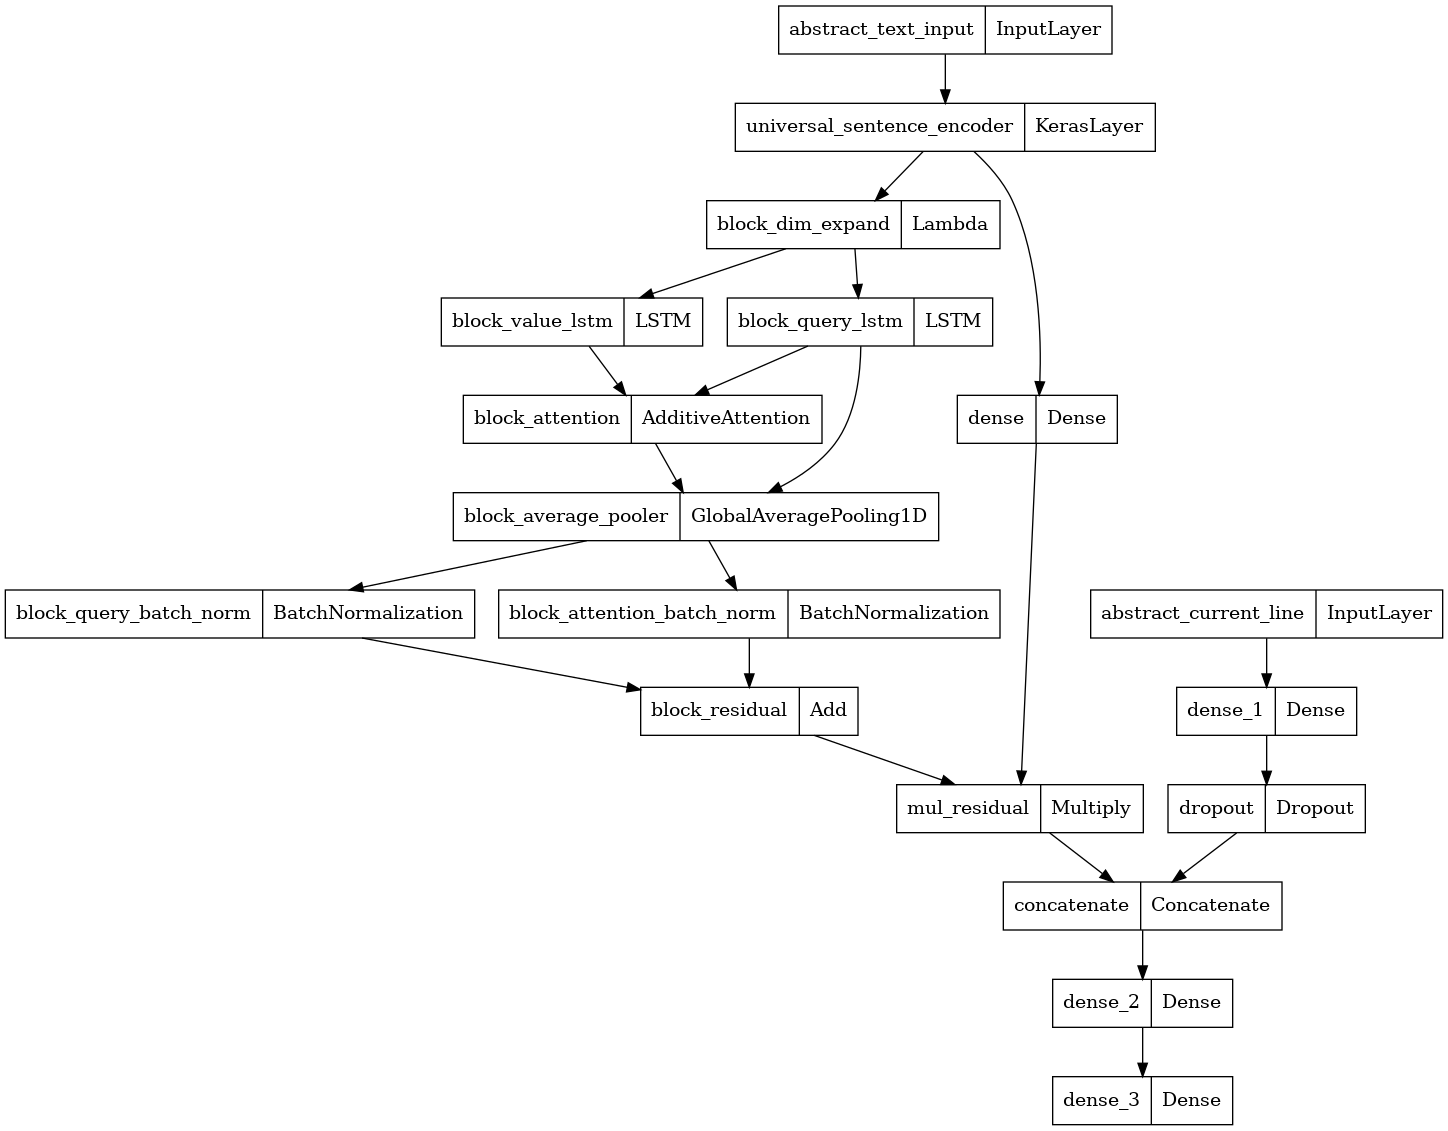

In [78]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png')


---

In case it is not rendering! Also, run the following on Linux:

```bash
sudo apt-get install graphviz
```

---

### 3.5 Model Training

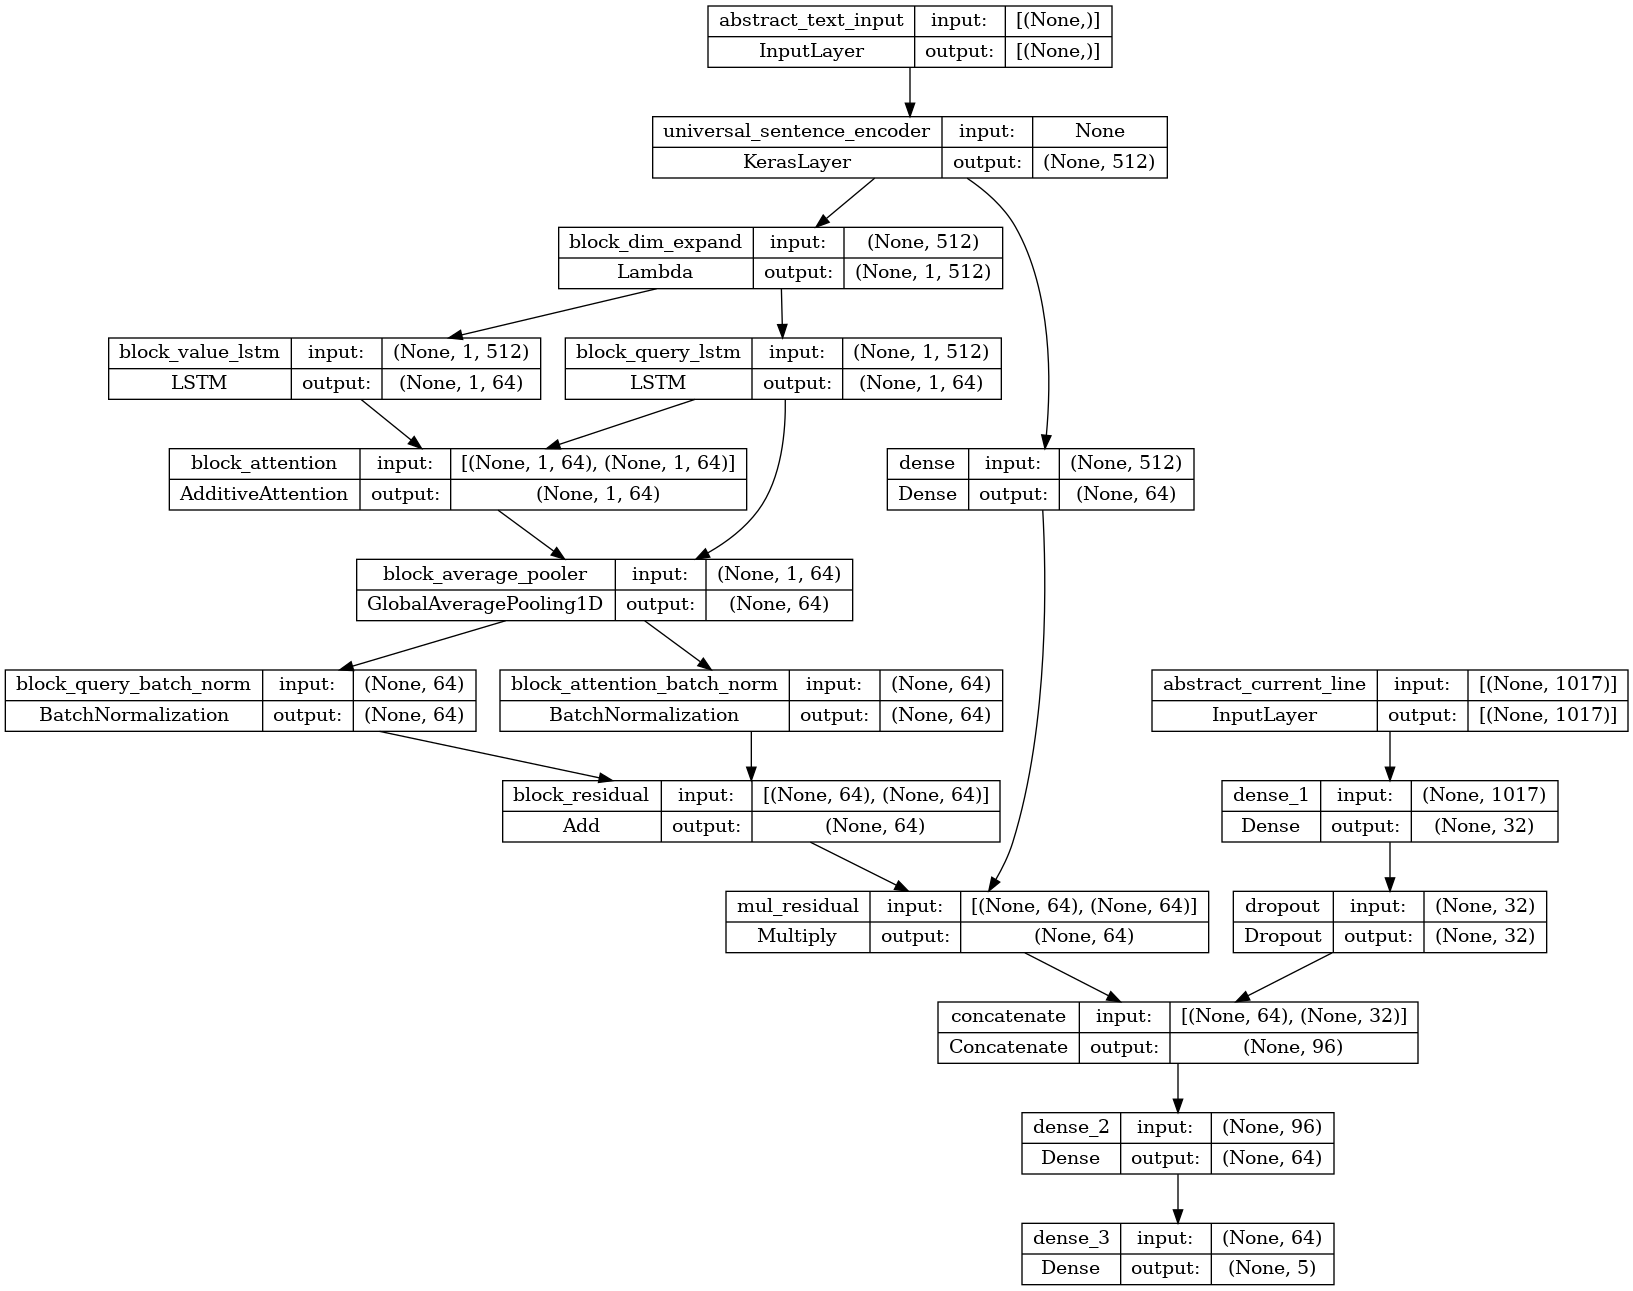

In [79]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='model.png')


In [80]:
%load_ext tensorboard
import datetime
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)


In [81]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):
    
    model_history = {}
    
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

We want to utilize early stopping to find the taper point in the training process.

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [82]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

EPOCHS = 20
CALLBACKS = [early_stopping_callback, reduce_lr_callback, tensorboard_callback]
METRICS = ['accuracy']

We would also need to set seed, the reason behind can be found at:

https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy

In [ ]:
# def set_seed(seed: int = 42) -> None:
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     # When running on the CuDNN backend, two further options must be set
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     # Set a fixed value for the hash seed
#     os.environ["PYTHONHASHSEED"] = str(seed)
#     print(f"Random seed set as {seed}")


In [ ]:
# def set_seed(seed: int = 42) -> None:
#   random.seed(seed)
#   np.random.seed(seed)
#   tf.random.set_seed(seed)
#   tf.experimental.numpy.random.seed(seed)
#   tf.set_random_seed(seed)
#   # When running on the CuDNN backend, two further options must be set
#   os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
#   os.environ['TF_DETERMINISTIC_OPS'] = '1'
#   # Set a fixed value for the hash seed
#   os.environ["PYTHONHASHSEED"] = str(seed)
#   print(f"Random seed set as {seed}")


In [ ]:
tf.random.set_seed(10) # To be honest, I don't know what number we should go for

In [ ]:


model.compile(
    # We use the categorical instead of default binary cross entropy
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model.name}.')
print(f'Train on {train_sentences_count} samples, validate on {val_sentences_count} samples.')
print('----------------------------------')

model_history = train_model(
    model, EPOCHS, CALLBACKS, 
    train_pipes, val_pipes,
    shuffling=False
)

Training use_attention_model.
Train on 2211861 samples, validate on 28932 samples.
----------------------------------


2023-06-03 08:32:20.233285: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 8997850548 exceeds 10% of free system memory.


Epoch 1/20
52301/69121 [=====================>........] - ETA: 4:32 - loss: 0.6278 - accuracy: 0.8778